# Topological Data Analysis

# Libraries

In [1]:
# Reload modules before executing user code
%load_ext autoreload
# Reload all modules every time before executing the Python code
%autoreload 2

In [2]:
# Data wrangling
import numpy as np
import pandas as pd

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt
from plotting import plot_crash_detections, plot_crash_comparisons
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))

# TDA
import gtda.time_series as ts
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr
from gtda.plotting import plot_diagram, plot_point_cloud
from gtda.pipeline import Pipeline

# Load World Wealth Data

In [27]:
WW= pd.read_csv('WORLD_WEALTH.csv',parse_dates=True)
WW['Date'] = pd.to_datetime(WW['Date'], errors='coerce', dayfirst=True)
WW = WW.set_index(['Date'])

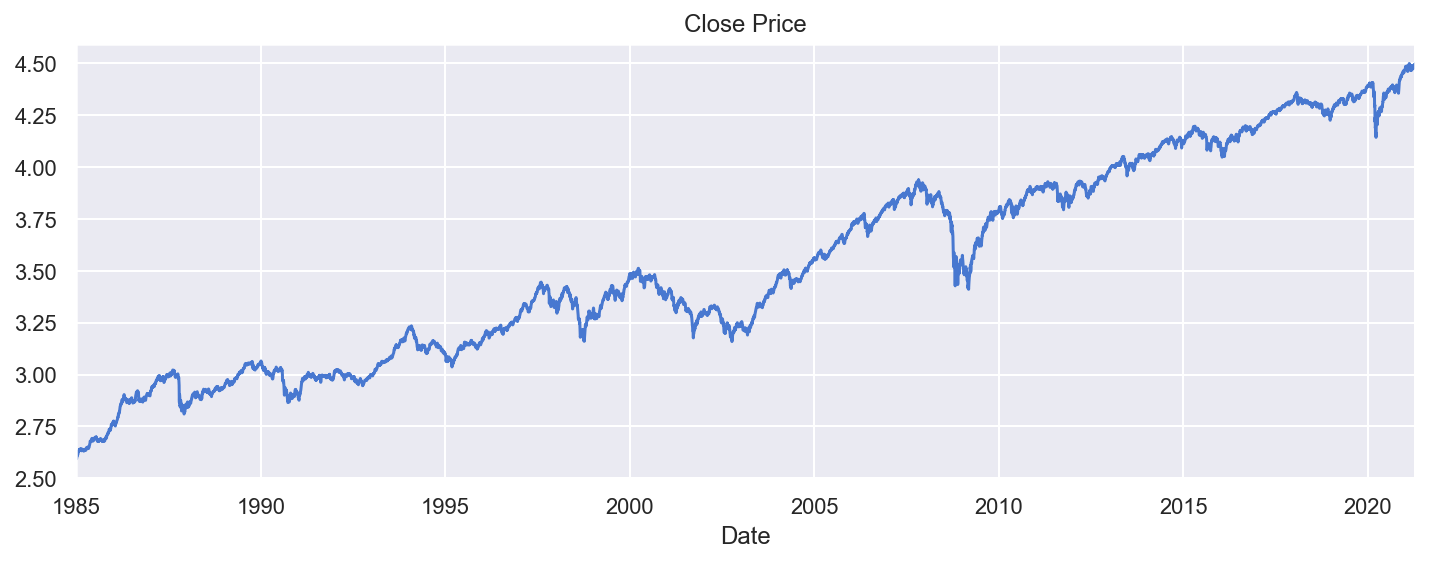

In [29]:
price_df = WW['WW']
price_df.plot()
plt.title('Close Price')
plt.show()

# Resample Data

The nature of the code means we have to resample to evenly-spaced daily values - this means we have to fill in data over the weekends.

In [30]:
start_year = '1985'
# use pad to replace missing values by last non-missing value
price_resampled_df = price_df.resample('24H').pad()[start_year:]

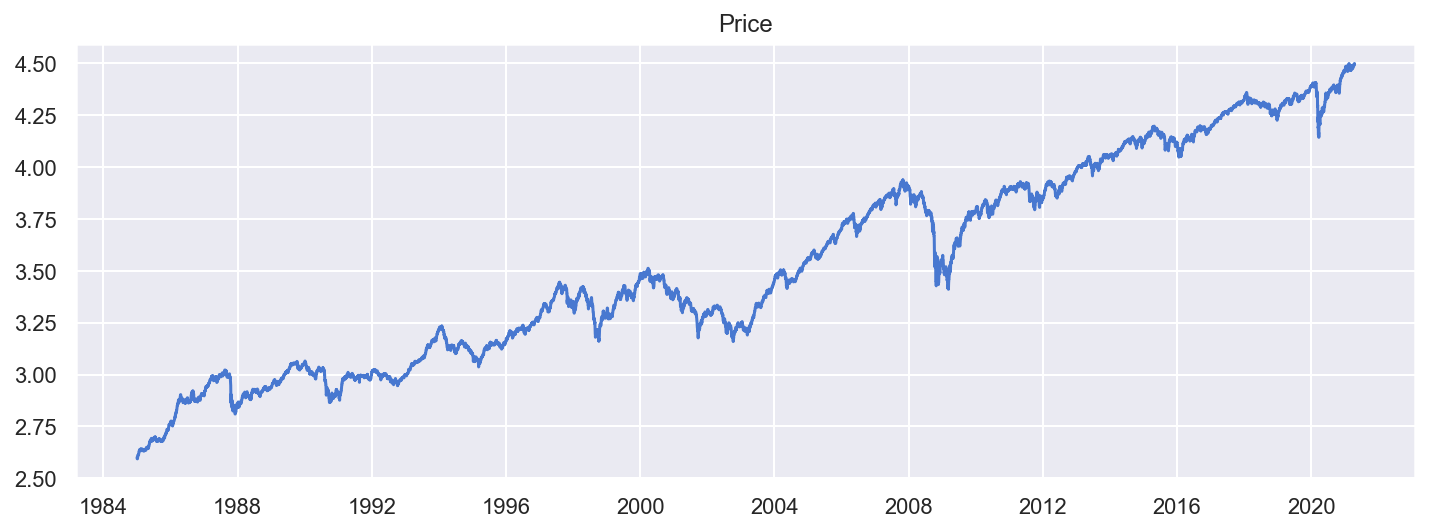

In [33]:
plt.plot(price_resampled_df)
plt.title('Price')
plt.show()

# Time Series as Point Clouds

The basis of the analysis is built on the idea that some key properties of time series (including, but more general than, periodicity or quasi-periodicity as seen by Fourier analysis) can be unveiled y in higher dimensions. This means you can represent a univariate time series (or a single temporal window over that time series) as a point cloud, i.e. a set of vectors in a Euclidean space of arbitrary dimension.

The following is a little beyond me but works as follows:

We pick two integers  𝑑  and  𝜏 . For each time  𝑡𝑖∈(𝑡0,𝑡1,…) , we collect the values of the variable  𝑦  at  𝑑  distinct times, evenly spaced by  𝜏  and starting at  𝑡𝑖 , and present them as a vector with  𝑑  entries. The result is a set of vectors in  𝑑 -dimensional space!  𝜏  is called the time delay parameter, and  𝑑  the embedding dimension.

This time-delay embedding technique is  called Takens' embedding.

The outer window allows us to apply Takens embedding locally on a certain interval rather than over the whole time series. The result of this procedure is therefore a time series of point clouds with possibly interesting topologies.

In [34]:
embedding_dimension = 3
embedding_time_delay = 2

In [35]:
embedder = ts.SingleTakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

Now that our embedder is initialised, it is a simple matter to obtain an array of embeddings, where each element is a 3-dimensional vector:

In [36]:
price_values = price_resampled_df.values
price_embedded = embedder.fit_transform(price_values)

embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

Next we apply a sliding window to obtain the point clouds per window. The original paper has a span of 32 days, but this is designed for the S&P - for WW I think a window half the size is more appropriate due to its diversification properties- but it may be possible to calculate an optimum length (I do not know how).

In [75]:
window_size = 14
window_stride = 2

In [76]:
sliding_window = ts.SlidingWindow(size=window_size, stride=window_stride)
price_embedded_windows = sliding_window.fit_transform(price_embedded)

We can visualise any point cloud from the data - this is one just chosen at random.

In [77]:
window_num = 25
point_cloud = price_embedded_windows[window_num][:, :3]
plot_point_cloud(point_cloud)

## Baseline Anomaly Detector
Here we create a simple baseline that tracks the first derivative of our time series over a sliding window. By using the `SlidingWindow` class from `giotto-learn` we can quickly obtain arrays.

In [78]:
window_size_price = window_size + embedder_dimension * embedder_time_delay - 2
sliding_window_price = ts.SlidingWindow(size=window_size_price, stride=window_stride)
window_indices = sliding_window_price.slice_windows(price_values)
price_windows = sliding_window_price.fit_transform(price_values)

In [79]:
abs_derivative_of_means = np.abs(np.mean(np.diff(price_windows, axis=0), axis=1))

In [80]:
# define time index to combine with numpy arrays
indices = [win[1] - 1 for win in window_indices[1:]]
time_index_derivs = price_resampled_df.iloc[indices].index

In [81]:
resampled_close_price_derivs = price_resampled_df.loc[time_index_derivs]

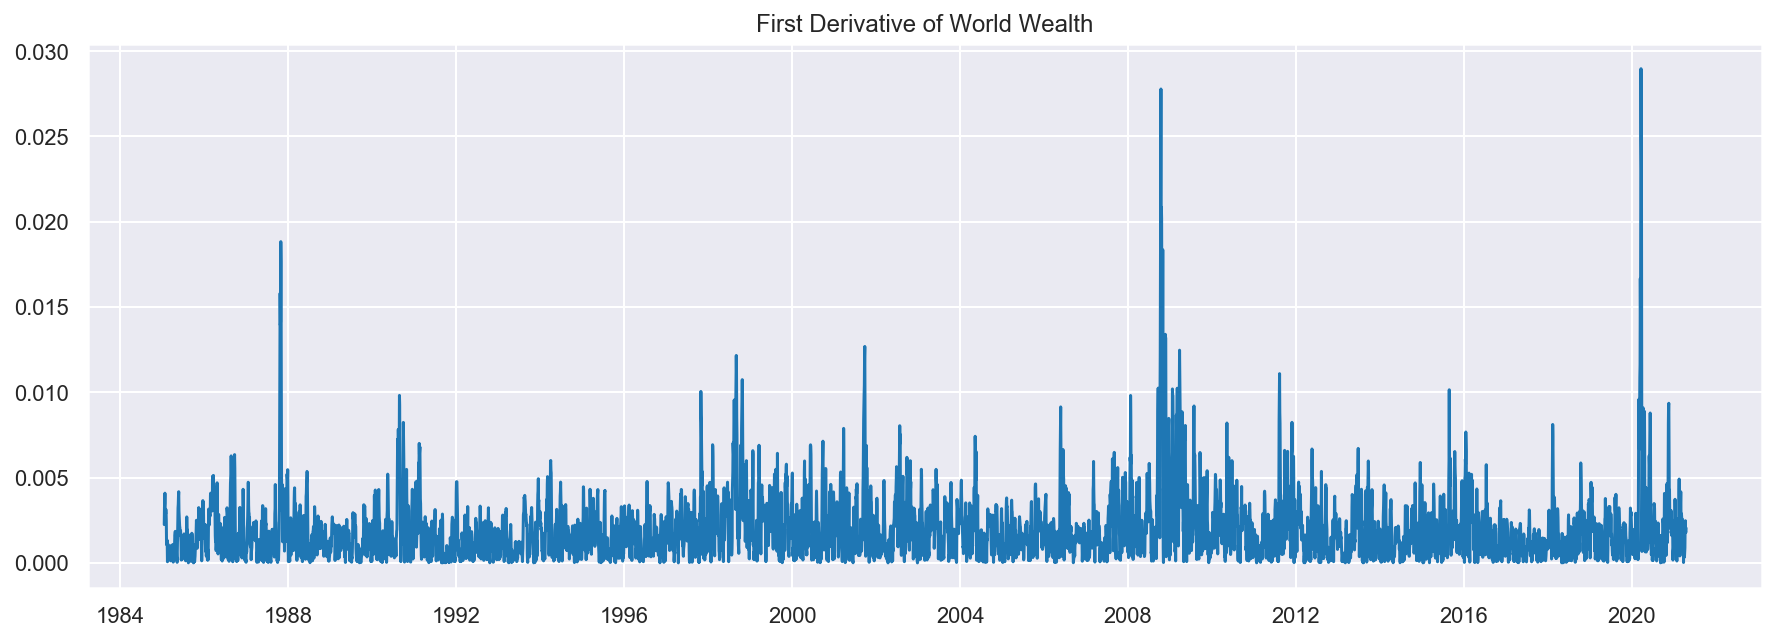

In [82]:
plt.figure(figsize=(15,5))
plt.plot(time_index_derivs, abs_derivative_of_means, color='#1f77b4')
plt.title('First Derivative of World Wealth')
plt.savefig('./images/metric_first_derivative.png')
plt.show()

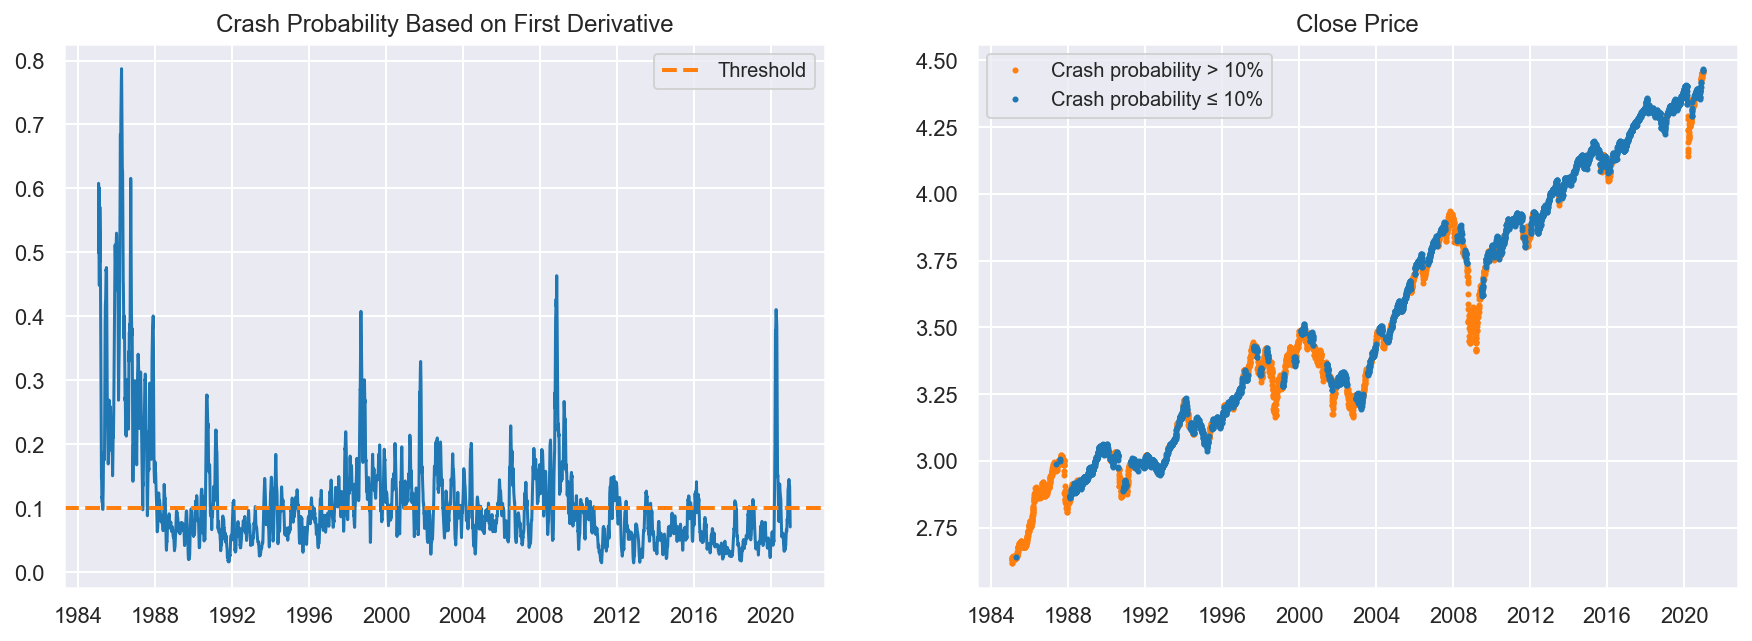

In [100]:
plot_crash_detections(
    start_date="1980-01-01",
    end_date="2021-01-01",
    threshold=0.1,
    distances=abs_derivative_of_means,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='First Derivative'
)

This works surprisingly well - but it triggers an awful lot and it also seems to get jumpy at the bottom on multiple occassions post GFC and in 1992.

## Persistence diagrams

The first step in a TDA pipeline typically involves calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. The horizontal axis corresponds to the moment in which a homological generator is created, while the vertical axis corresponds to the moments in which an homological generator disapears.

In [85]:
# define the number of homology dimensions to track
homology_dimensions = (0, 1)
VR = hl.VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=-1)
diagrams = VR.fit_transform(price_embedded_windows)

In the plot below for a single window, the generators of each homology dimension  𝐻0  and  𝐻1  are coloured differently. As mentioned, y axis equals dissapearance of homological generator and x is creation. :

In [86]:
VR.plot(diagrams, sample=window_num)

## Homological derivatives

Given a persistence diagram, there are a number of possible features that can derived from it. For our application, we are interested in calculating the distance between diagrams obtained from two successive windows. Although one can calculate this directly from the `PairwiseDistance` class, here I utilise `giotto-learn`'s API to create a custom transformer:

In [87]:
from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams
from gtda.utils.validation import check_diagrams


class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):

        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])

        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)

        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)
            Xt = Xt.reshape(len(self.homology_dimensions_), len(X) - 1).T
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

With our transformer defined, we can use it to calculate the successive distance between diagrams using the landscape distance:

In [88]:
metric_params = {"p": 2, "n_layers": 10, "n_bins": 1000}

landscape_hom_der = HomologicalDerivative(
    metric="landscape", metric_params=metric_params, order=2, n_jobs=-1
)
landscape_succ_dists = landscape_hom_der.fit_transform(diagrams)

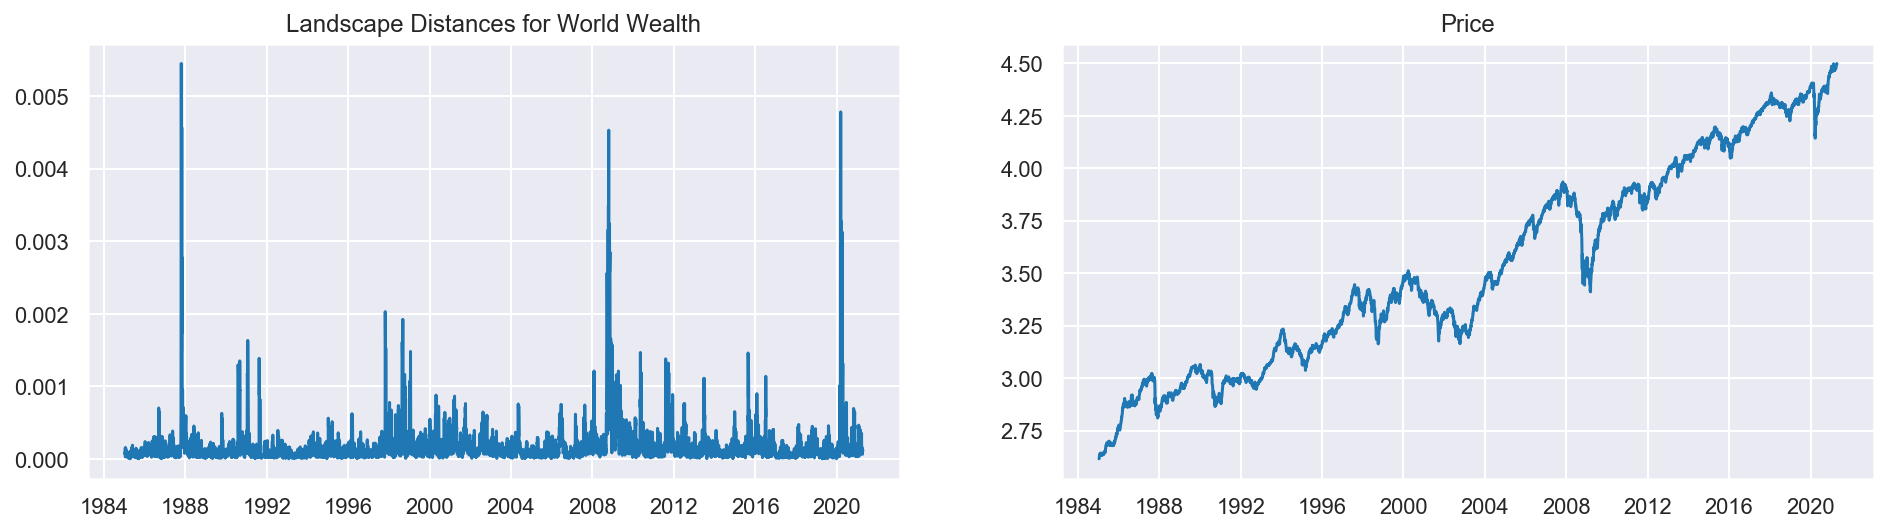

In [104]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, color="#1f77b4")
plt.title("Landscape Distances for World Wealth")

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs, "#1f77b4")
plt.title("Price")
plt.show()

## Distances among diagrams using Betti curves

Alternatively we can compute distance using Betti curves.

In [90]:
metric_params = {"p": 2, "n_bins": 1000}


bettiHomDer = HomologicalDerivative(
    metric='betti', metric_params=metric_params, order=2, n_jobs=-1
)
betti_succ_dists = bettiHomDer.fit_transform(diagrams)

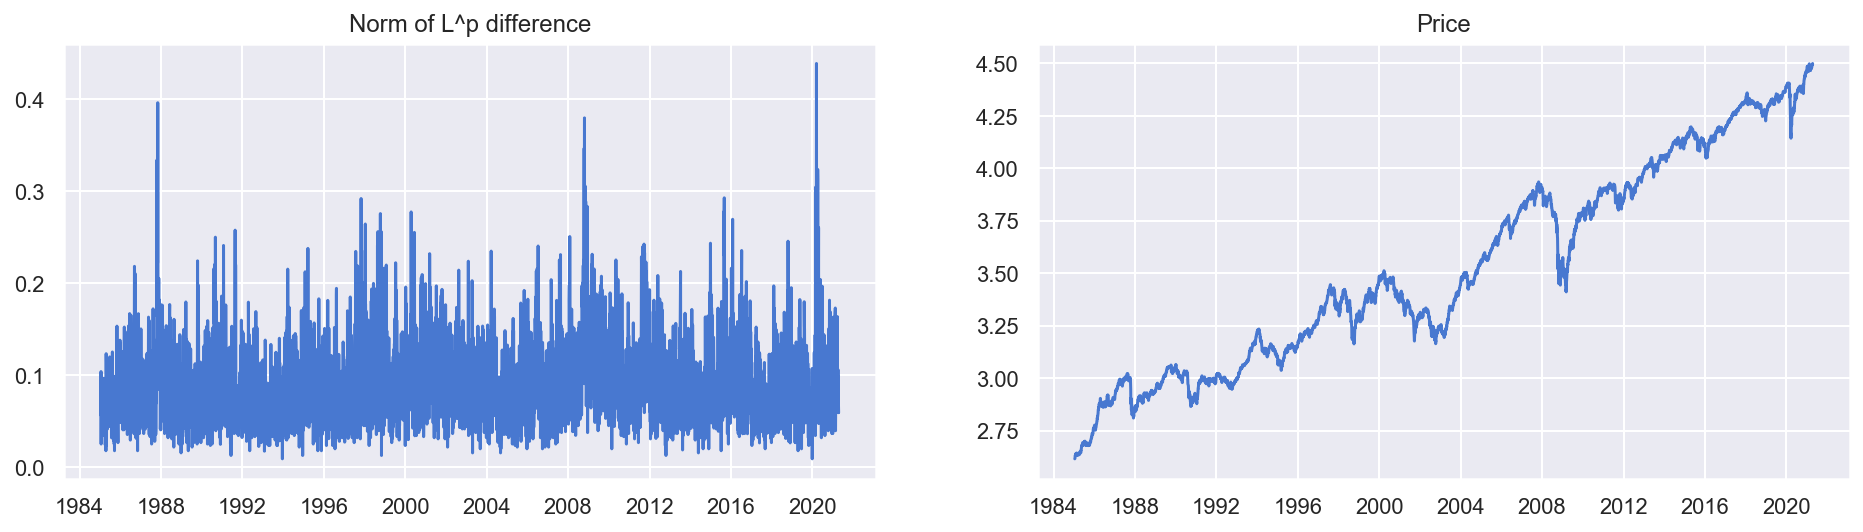

In [91]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, betti_succ_dists)
plt.title('Norm of L^p difference')

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs)
plt.title('Price')
plt.show()

# Comparing the Distance Measures

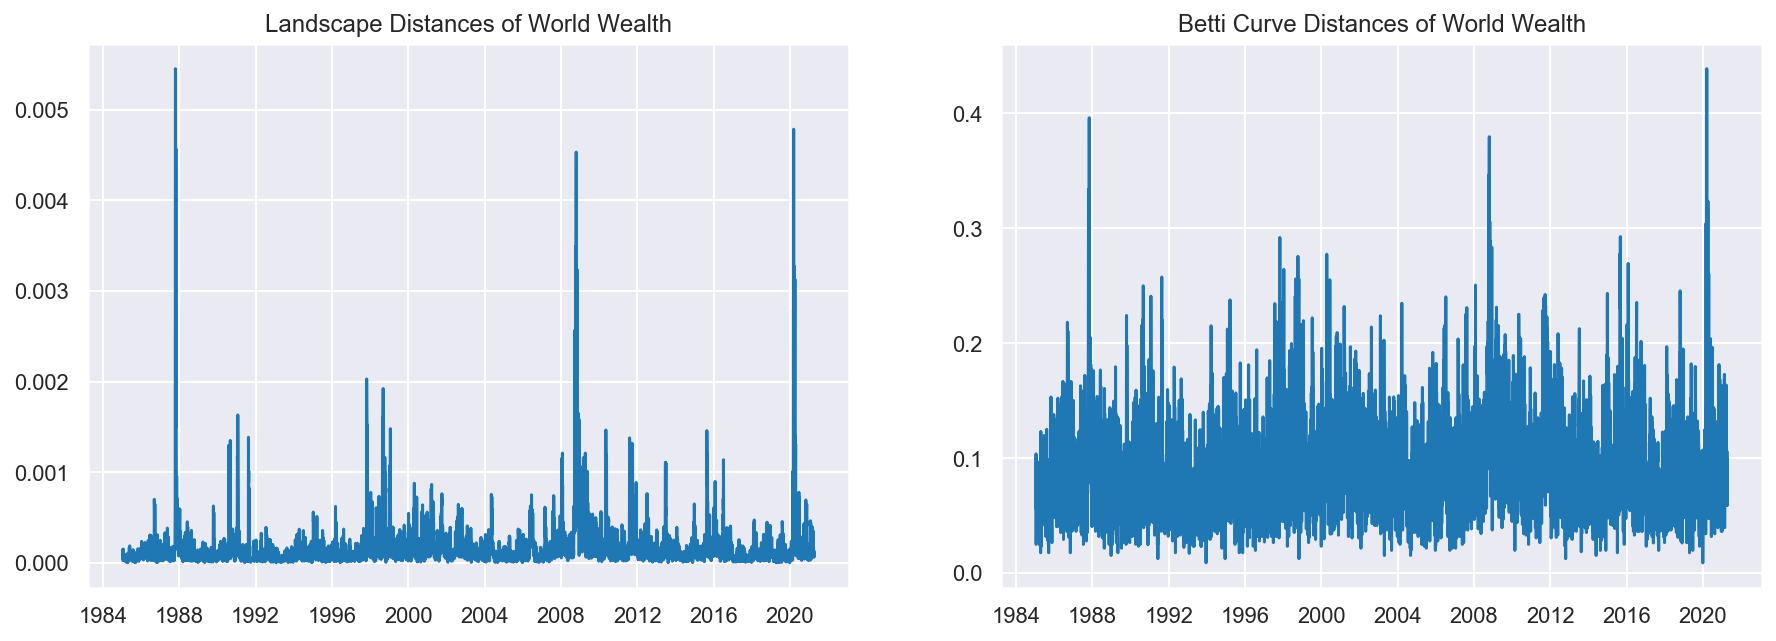

In [105]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, "#1f77b4")
plt.title("Landscape Distances of World Wealth")

plt.subplot(1, 2, 2)
plt.plot(time_index_derivs, betti_succ_dists, "#1f77b4")
plt.title('Betti Curve Distances of World Wealth')
plt.savefig('./images/metric_landscape_betti.png')
plt.show()

I'm only eyeballing the charts here, but due to the overwelming noise in the Betti curve distance measure it would appear to be more sensible to use landscape distances.

# Topological indicators for crashes

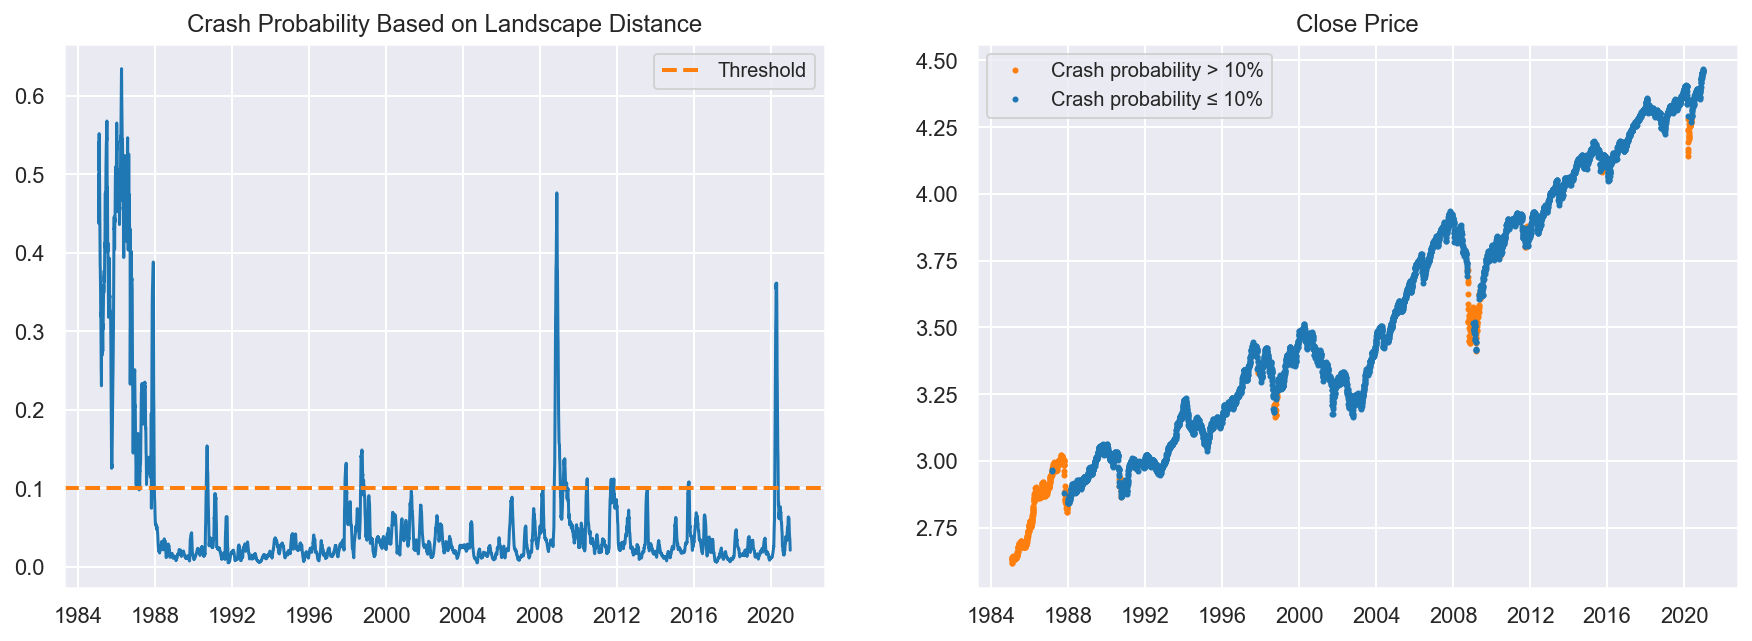

In [99]:
plot_crash_detections(
    start_date="1980-01-01",
    end_date="2021-01-01",
    threshold=0.10,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

# COVID

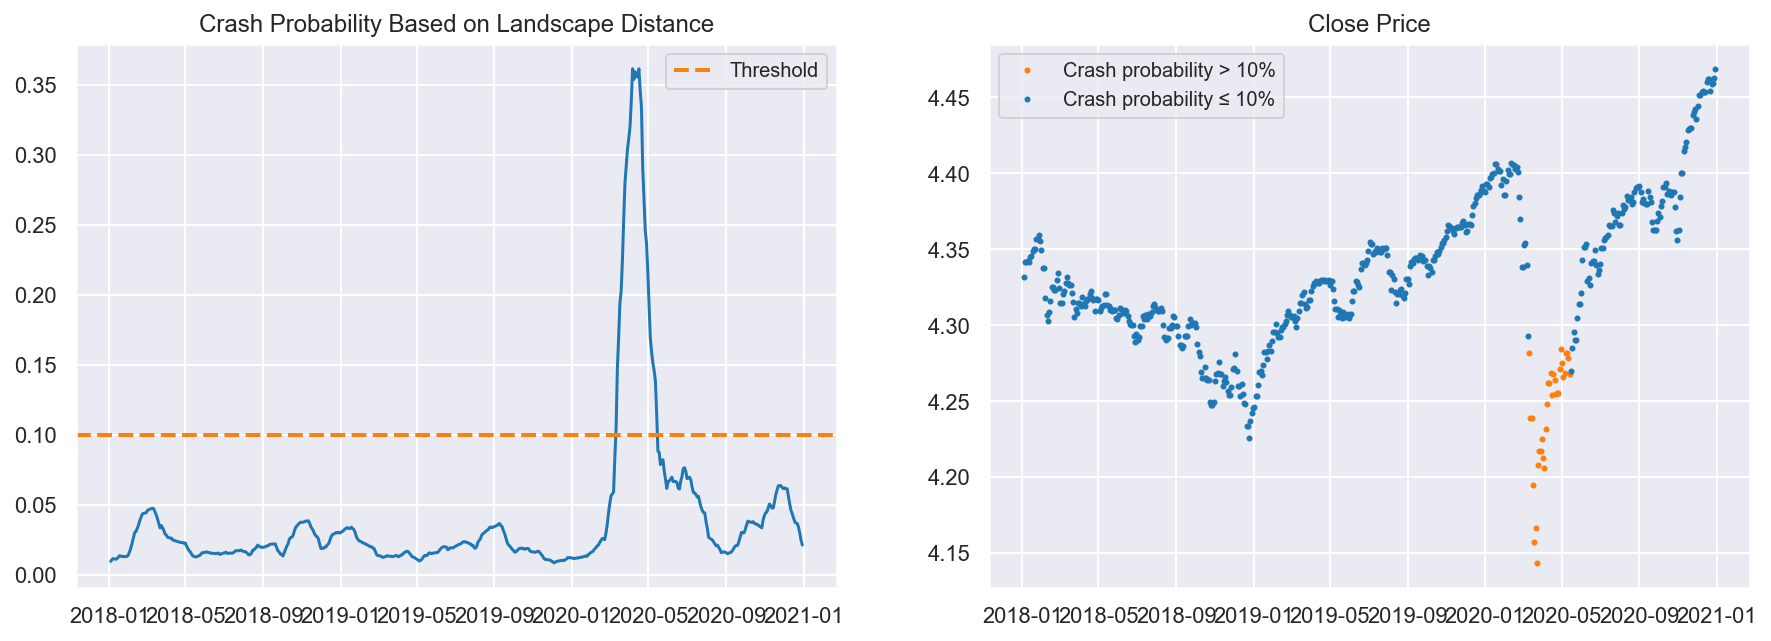

In [101]:
plot_crash_detections(
    start_date="2018-01-01",
    end_date="2021-01-01",
    threshold=0.10,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

# GFC

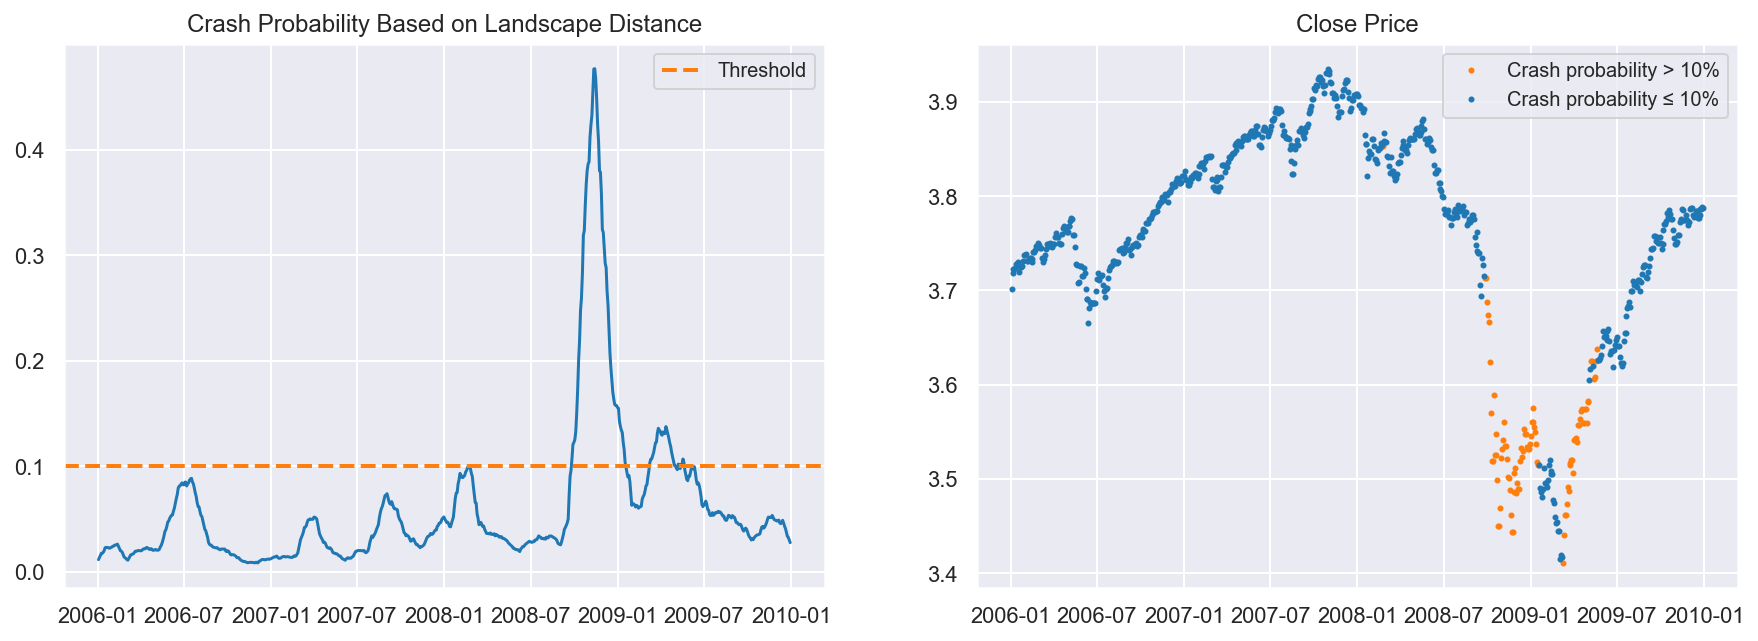

In [102]:
plot_crash_detections(
    start_date="2006-01-01",
    end_date="2010-01-01",
    threshold=0.10,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

# Tech Bubble

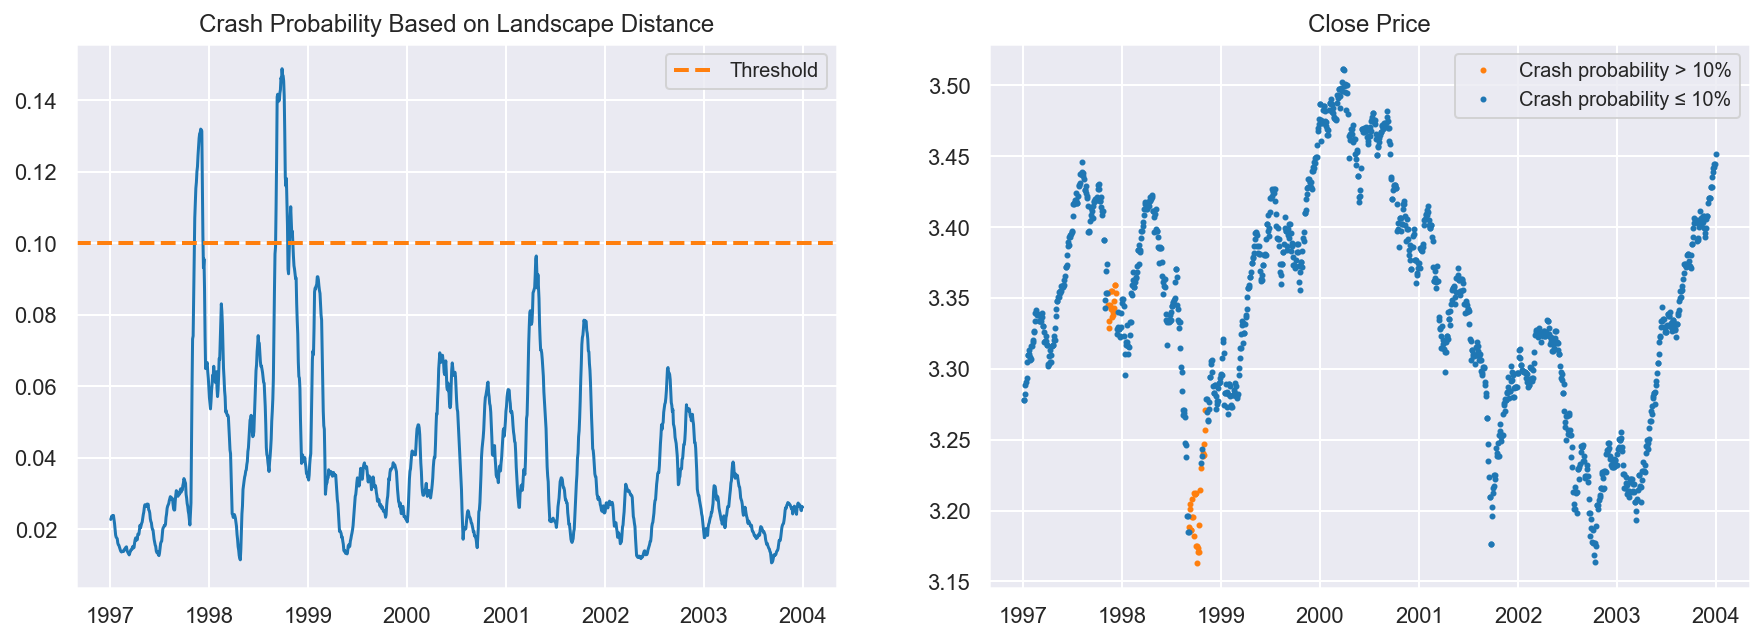

In [106]:
plot_crash_detections(
    start_date="1997-01-01",
    end_date="2004-01-01",
    threshold=0.10,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)